# A behavioural analog to BCI training : results

Statistics and simple plots of the results of the experiment (technical test). 

This notebook does not figure much computational modeling (yet).


Let's start by importing the necessary packages as well as the data : 

 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.
A total of 33/15950 actions were missed. (0.21 %)
(145, 3)


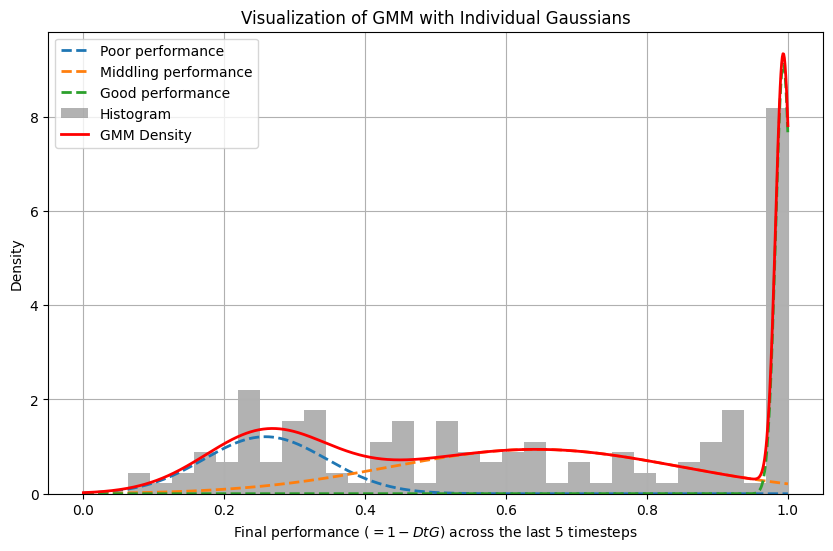

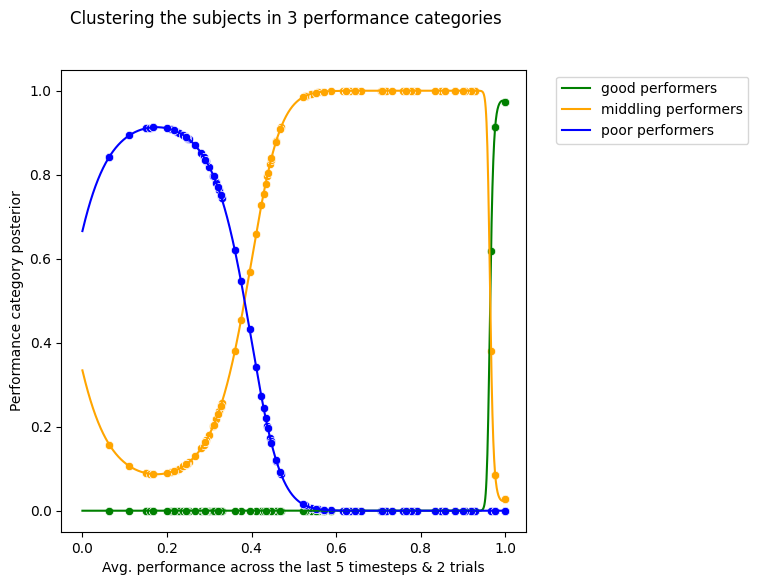

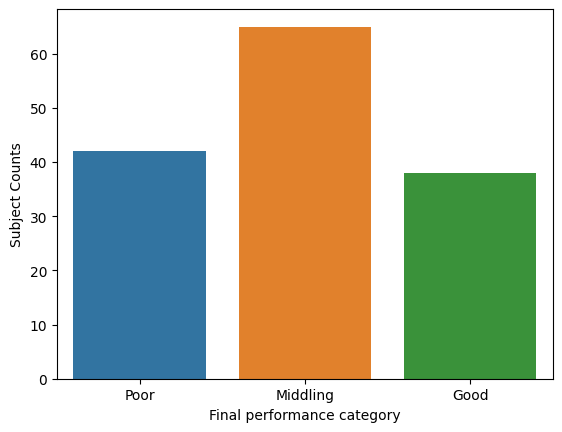

In [1]:

import sys,os
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.mixture import GaussianMixture

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df
from analysis_tools.dataframe_from_raw_data import get_full_dataframe_from_raw_data

LLM_CLASSIFS_PATH = os.path.join("results","llm_classifications","29_01.data")

STUDIES_EXTRACTION_CODES = {
    # "study_1" : {
    #     "dict_code" : "002",
    #     "internal_task_id" : "002",
    #     "studies_id" : None,
    #     "exclude_subjects" : ["5c9cb670b472d0001295f377"],
    #     "feedback_noise_bins" : [0,0.2,0.4,1]
    # },
    # "study_2" : {
    #     "dict_code" : "003_1",
    #     "internal_task_id" : "003",
    #     "studies_id" :  ["66f96c31e69227986334a027","66d086503c0a69291c361b67"],
    #     "exclude_subjects" : ["615c1741d4630b25e6bc1cb9"],
    #     "feedback_noise_bins" : [0,0.05,0.15,1]
    # },
    "study_3" : {
        "dict_code" : "003_2",
        "internal_task_id" : "003",
        "studies_id" : ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"],
        "exclude_subjects" : ["611d60c383f4f70ff4bc99fd", "66a74bdfdcaccdc0703894d5",
                              "667d92f2ea5c1542f417285d", "6548f570022275786186ffbd"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    }
}

LAST_T_TIMESTEPS = 5
LAST_K_TRIALS = 2
subjects_df = get_full_dataframe_from_raw_data(STUDIES_EXTRACTION_CODES,LLM_CLASSIFS_PATH,LAST_T_TIMESTEPS,LAST_K_TRIALS)

## Interesting questions : 

How do our participants decision-making evolve when they get a negative feedback ? A positive feedback ?


10
(42, 99)
(65, 99)
(38, 99)


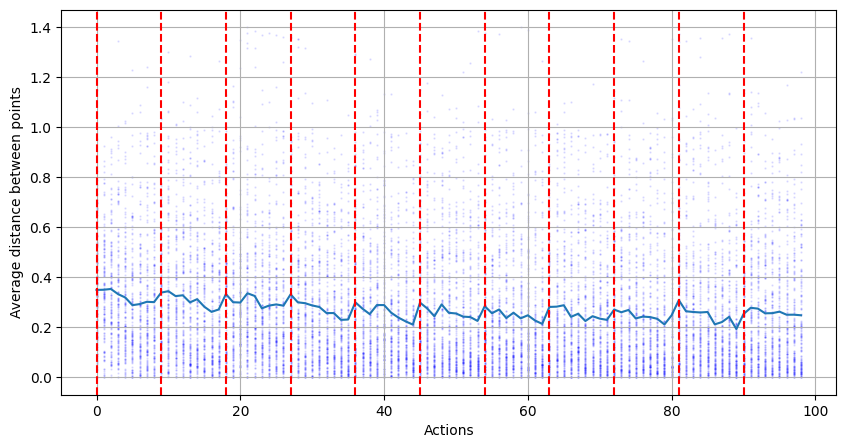

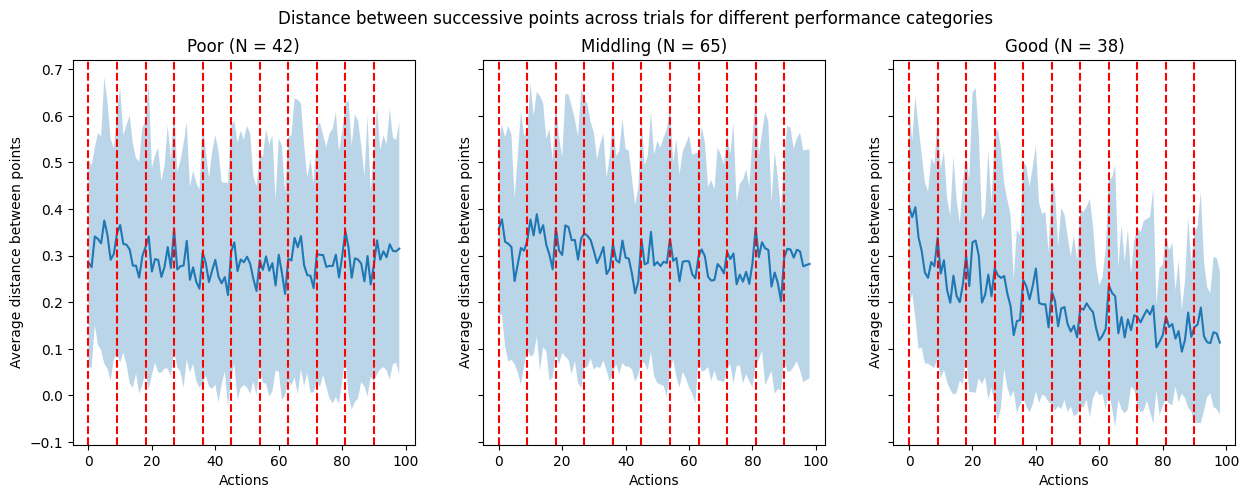

In [2]:
copy_df = subjects_df.copy()

# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))
copy_df["dist_between_successive"] = list(flattened_distance)
print(Nactions)

# Average distance between points :
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.grid()
for subj in range(Nsubj):
    ax.scatter(np.arange(flattened_distance[subj].size),flattened_distance[subj],c="b",alpha=0.1,s=0.5)
ax.plot(np.arange(flattened_distance[subj].size),np.mean(flattened_distance,axis=0))
for trial in range(Ntrials):
    ax.axvline(trial*(Nactions-1),linestyle="--",color="r")
ax.set_xlabel("Actions")
ax.set_ylabel("Average distance between points")


# Group by performances : 
Nsubcat = 3
fig,axs = plt.subplots(1,Nsubcat,figsize=(15,5),sharey=True)
fig.suptitle("Distance between successive points across trials for different performance categories")
perf = list(subjects_df["final_performance"])

perf_bins = np.linspace(0-1e-5,1+1e-5,Nsubcat+1)
category = np.digitize(perf,perf_bins) - 1


perfcats = ["Poor","Middling","Good"]
for score in range(Nsubcat):
    ax = axs[score]    
    filtered_subjects = copy_df[copy_df["performance_category"] == perfcats[score]]
    
    filtered_metric = np.stack(filtered_subjects["dist_between_successive"])
    
    print(filtered_metric.shape)
    avg_plot = np.mean(filtered_metric,axis=0)
    std_plot = np.std(filtered_metric,axis=0)
    
    ax.fill_between(np.arange(avg_plot.shape[0]),avg_plot-std_plot,avg_plot+std_plot,alpha=0.3)
    ax.plot(np.arange(avg_plot.shape[0]),avg_plot)
    for trial in range(Ntrials):
        ax.axvline(trial*(Nactions-1),linestyle="--",color="r")
    ax.set_xlabel("Actions")
    ax.set_ylabel("Average distance between points")
    ax.set_title("{} (N = {})".format( perfcats[score],filtered_metric.shape[0]))


The exploration / exploitation shift is clearly visible in the last category of subjects, with a distinct decrease in the average variation in point position. This is far less visible in less successful subject categories.

In [20]:
# look_at_T_trials = 10

# # Observations : 
# list_of_subjects_rtf = list(subjects_df["realtime_values"])
# all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
# for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
#     list_of_last_fb = []
#     list_of_deltas = []
#     for trial_series in _subj_feedback_series:
#         trial_last_fbs = []
#         trial_delta_fbs = []
#         for timestep_series in trial_series:
#             initial_feedback_value = timestep_series[0][...,1]
#             final_feedback_value = timestep_series[-1][...,1]
            
#             # print(timestep_series[0,:])
            
#             trial_last_fbs.append(final_feedback_value)
            
#             delta_feedback = final_feedback_value - initial_feedback_value
#             trial_delta_fbs.append(delta_feedback)
                
#         list_of_last_fb.append(trial_last_fbs)
#         list_of_deltas.append(trial_delta_fbs)
    
#     all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
#     all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# # Action data :
# all_barycenters = np.stack(subjects_df["action_barycenters"],axis=0)
# all_angles = np.stack(subjects_df["action_angles"],axis=0)
# all_distances = np.stack(subjects_df["action_distances"],axis=0)
# all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# # Observation data :
# gauge_levels = np.array(all_subject_obs["gauge_level"])
# delta_gauges = np.array(all_subject_obs["delta_gauge"])


# positive_feedbacks = delta_gauges>=0
# negative_feedbacks = delta_gauges<0

# delta_feedbacks = np.reshape(negative_feedbacks[:,-look_at_T_trials:,1:-1],(Nsubj,-1))
#                                 # Remove the first timestep of each trial (reset to 0)
#                                 # And the last of each trial (no action after that one !)
#                                 # Also remove the second observation because only one action has been done before (thereofre, no action variation)

# # print(negative_feedbacks)
# print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
# print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# # Differences between barycenters at time t and time t+1 :
# diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# # Differences between angles at time t and time t+1 :
# diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]
# # Differences between distances at time t and time t+1 :
# diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
# Nsubj = diff_barycenters.shape[0]




Question : for a single action modality, how does the intensity of a variation relate to the variation of the other modalities.

5352 negatives /10598 positives
525 / 780 remaining after removing edge actions
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(145, 9) (145, 9)
(1

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\annic\AppData\Local\Temp\ipykernel_14172\2655106501.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploi

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


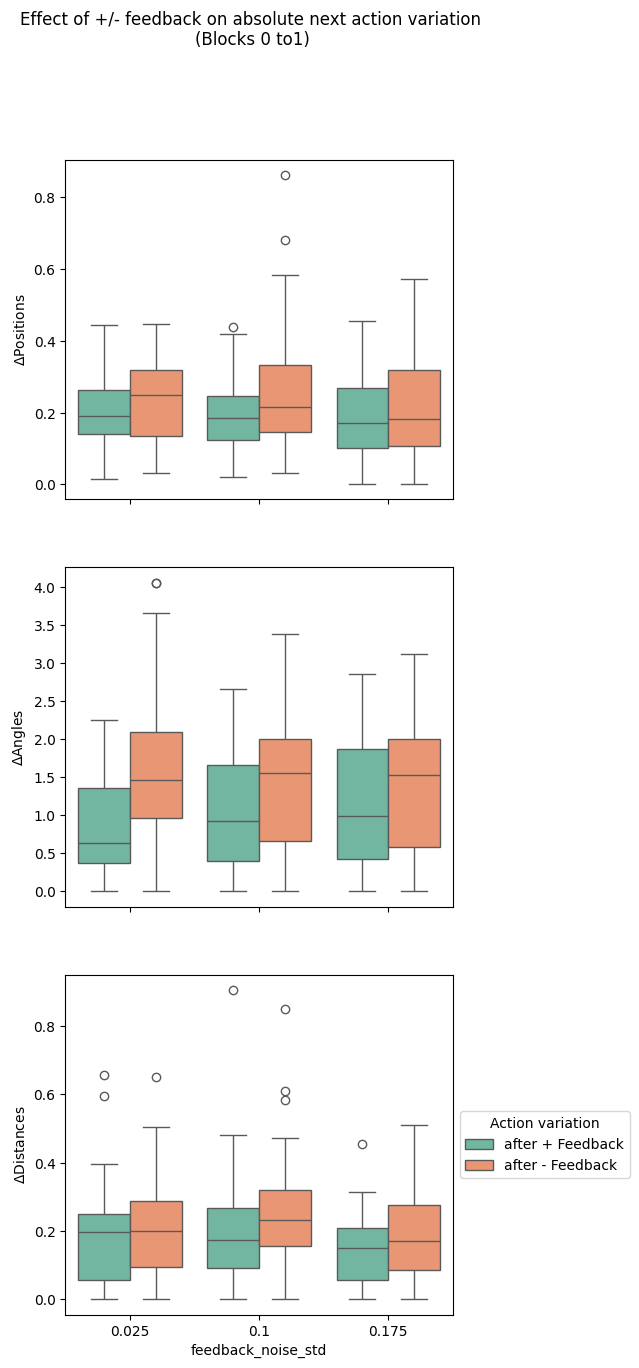

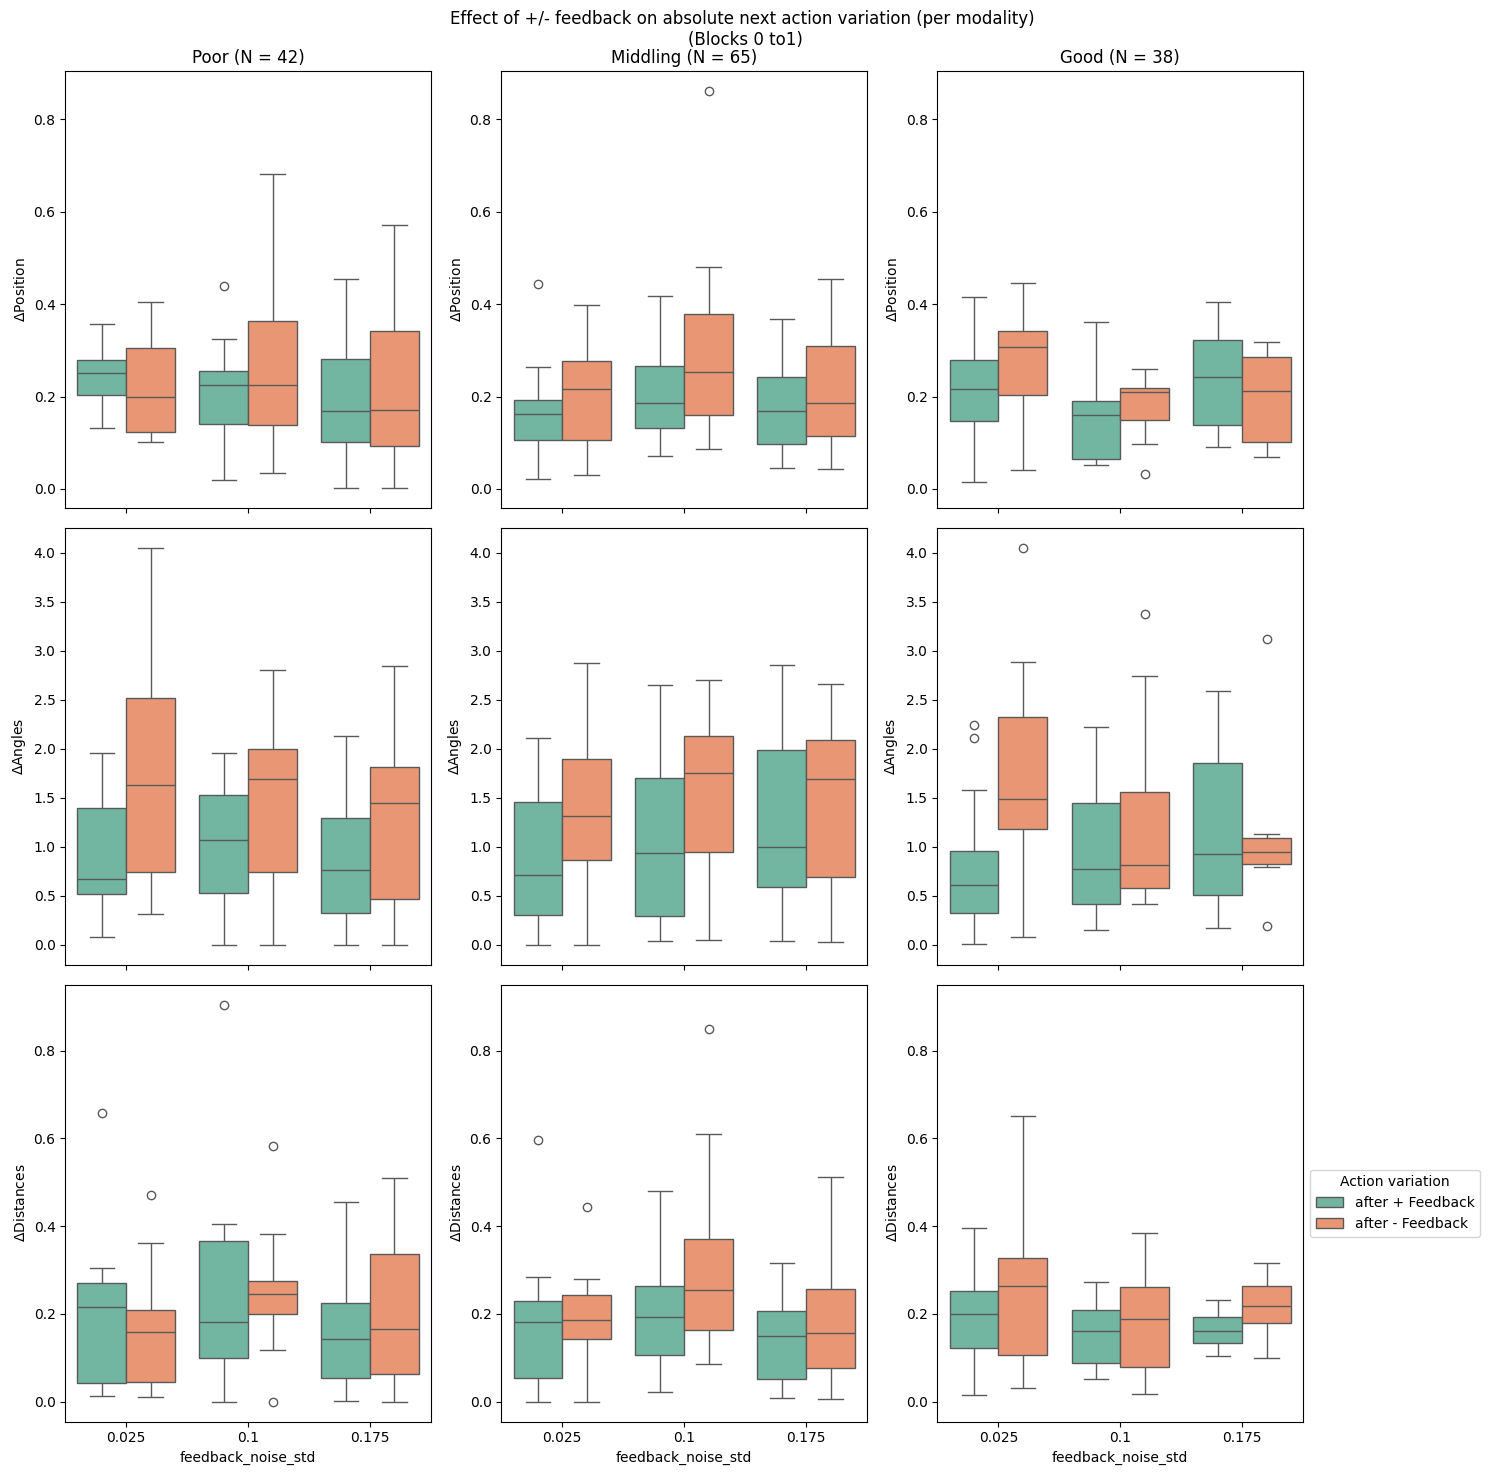

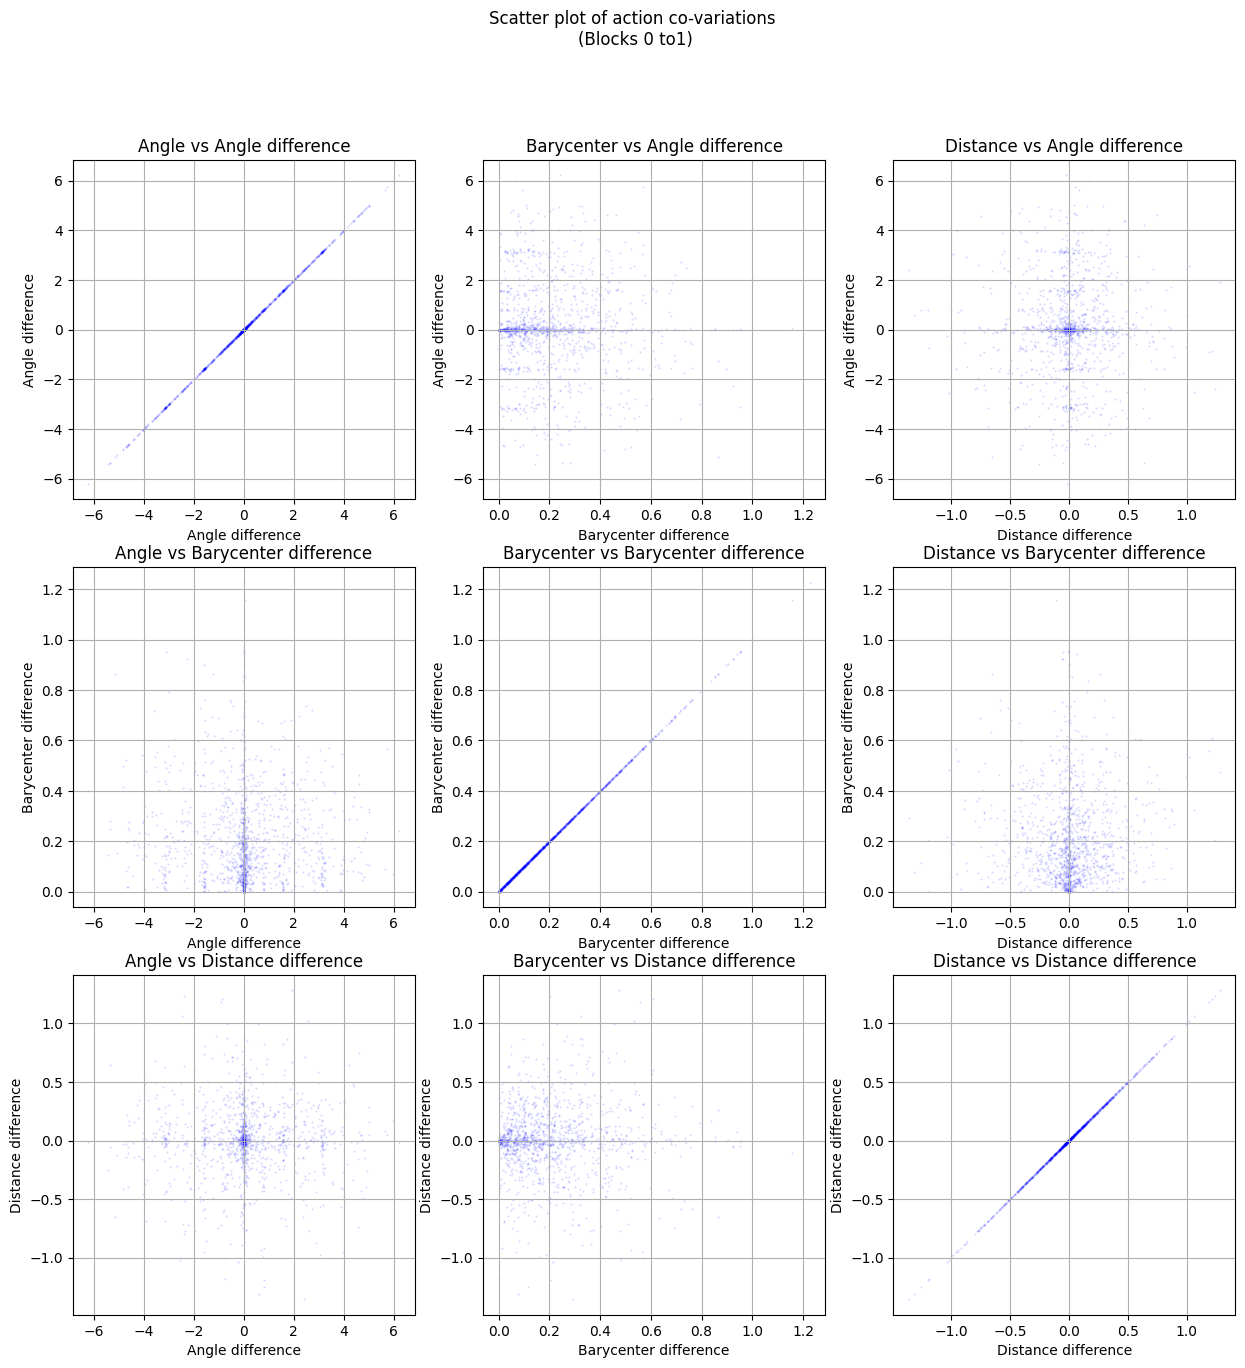

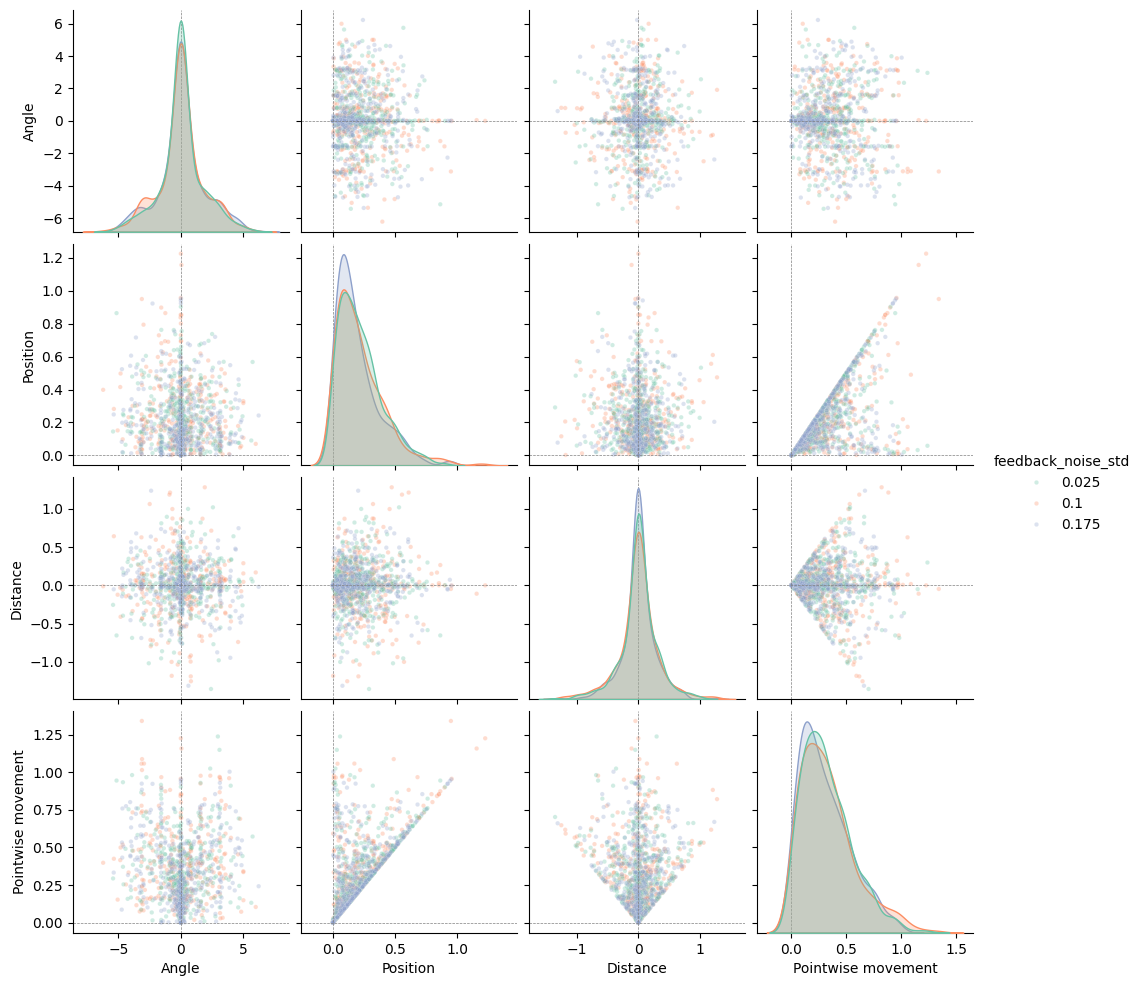

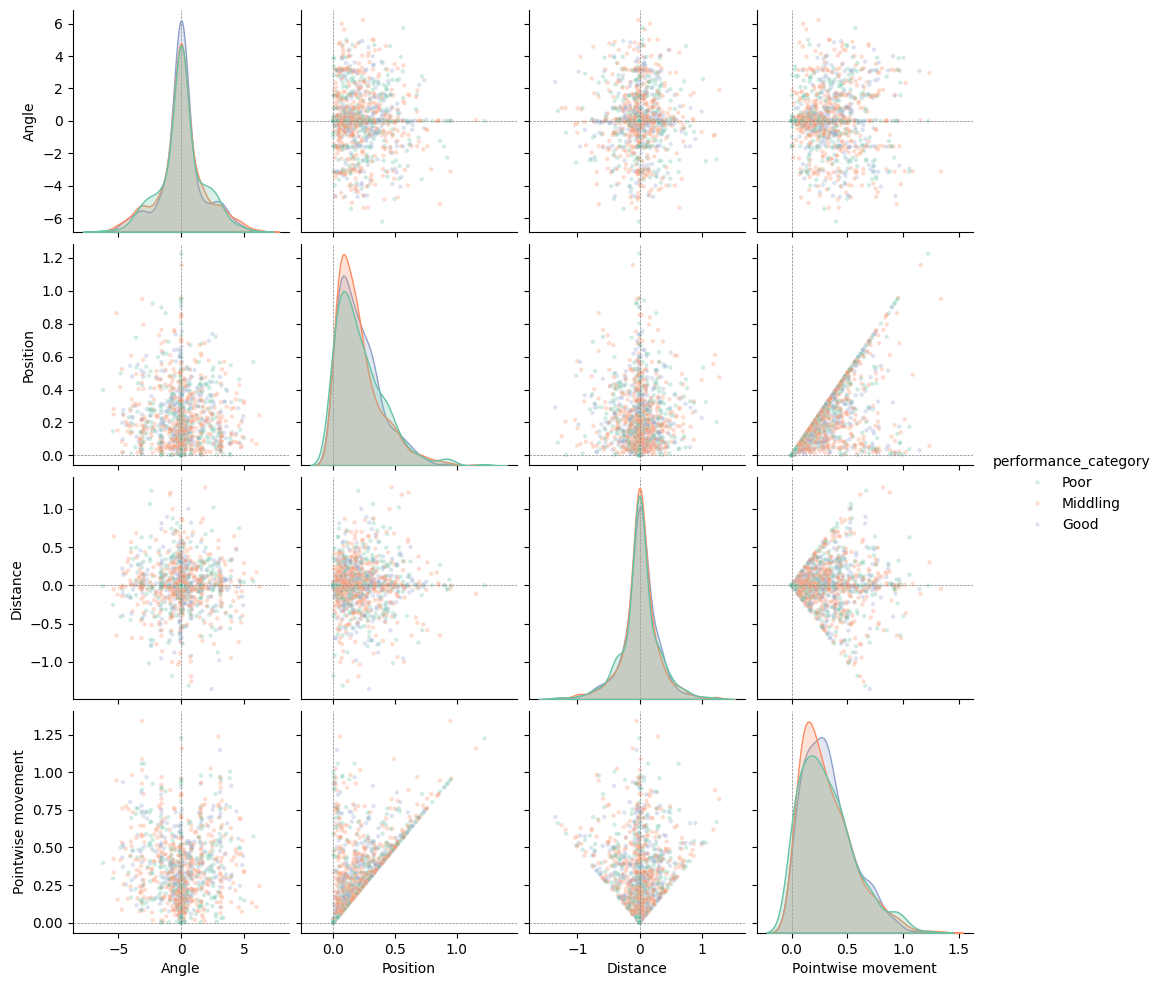

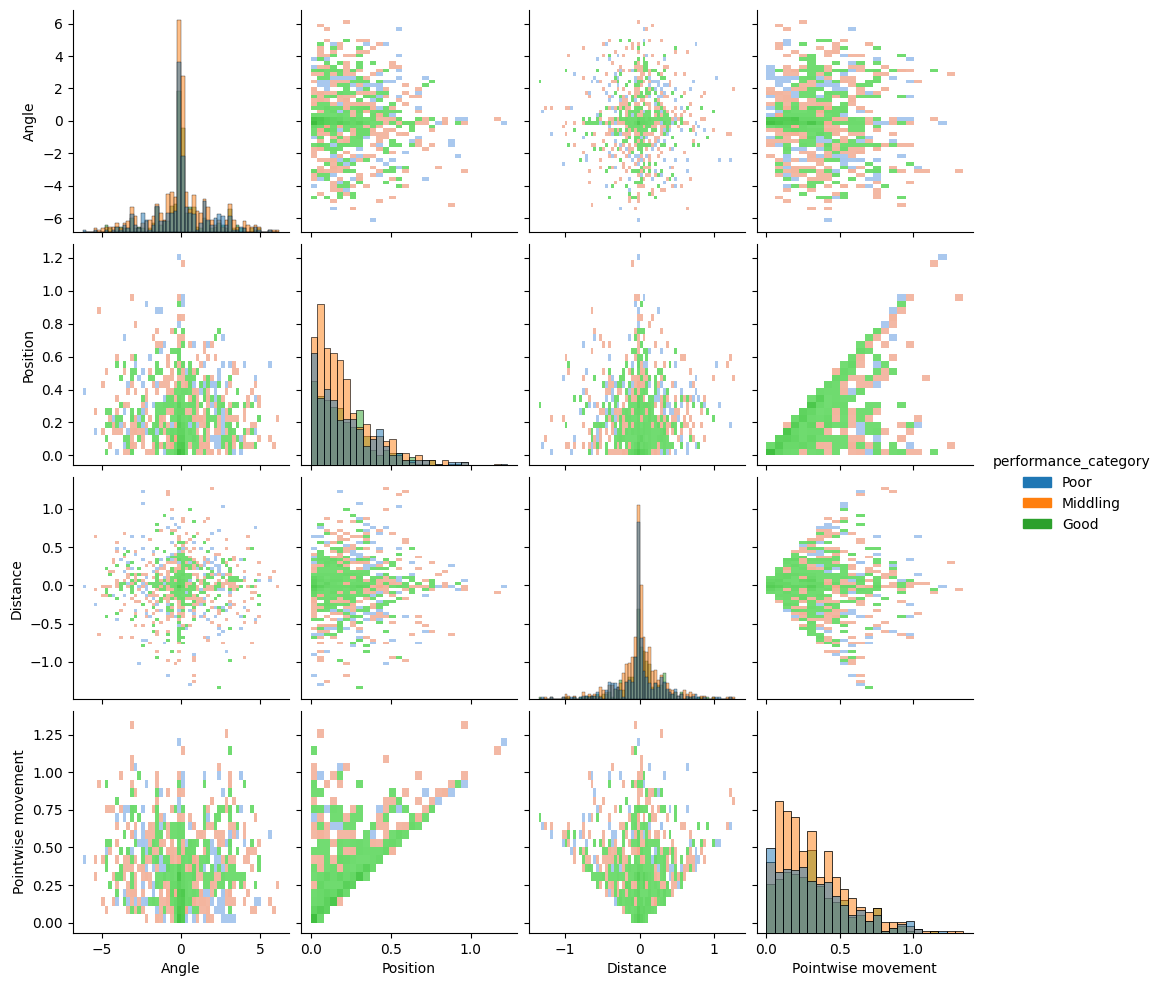

In [21]:

copy_df = subjects_df.copy()

look_between_a = 0
look_between_b = 1


# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Observations : 
list_of_subjects_rtf = list(subjects_df["realtime_values"])
all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
    list_of_last_fb = []
    list_of_deltas = []
    for trial_series in _subj_feedback_series:
        trial_last_fbs = []
        trial_delta_fbs = []
        for timestep_series in trial_series:
            initial_feedback_value = timestep_series[0][...,1]
            final_feedback_value = timestep_series[-1][...,1]
            
            # print(timestep_series[0,:])
            
            trial_last_fbs.append(final_feedback_value)
            
            delta_feedback = final_feedback_value - initial_feedback_value
            trial_delta_fbs.append(delta_feedback)
                
        list_of_last_fb.append(trial_last_fbs)
        list_of_deltas.append(trial_delta_fbs)
    
    all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
    all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# Action data :
all_barycenters = np.stack(subjects_df["action_barycenters"],axis=0)
all_angles = np.stack(subjects_df["action_angles"],axis=0)
all_distances = np.stack(subjects_df["action_distances"],axis=0)
all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# Observation data :
gauge_levels = np.array(all_subject_obs["gauge_level"])
delta_gauges = np.array(all_subject_obs["delta_gauge"])

positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0

delta_feedbacks = np.reshape(negative_feedbacks[:,look_between_a:look_between_b,1:-1],(Nsubj,-1))
                                # Remove the first timestep of each trial (reset to 0)
                                # And the last of each trial (no action after that one !)
                                # Also remove the second observation because only one action has been done before (thereofre, no action variation)

# print(negative_feedbacks)
print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]
# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

metrics_analyzed = [rdiff_barycenters,rdiff_angle,rdiff_distances]
labels_analyzed = ["$\Delta$Positions","$\Delta$Angles","$\Delta$Distances"]
perf_categories = ["Poor","Middling","Good"]

fig,firstaxs = plt.subplots(3,1,figsize=(5,15),sharex=True)
fig.suptitle("Effect of +/- feedback on absolute next action variation \n(Blocks {} to{})".format(look_between_a,look_between_b))
for i,(metric,label) in enumerate(zip(metrics_analyzed,labels_analyzed)):
    ax = firstaxs[i]
    metric_analyzed = np.abs(metric) # Take the absolute value



    plot_df = subjects_df[['final_performance', 'feedback_noise_std', 'performance_category']].copy()
    for subj in range(Nsubj):
        
        print(metric_analyzed.shape,delta_feedbacks.shape)
        action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
        action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

        plot_df.loc[subj,"after + Feedback"] = np.mean(action_variation_after_positive_feedback)
        plot_df.loc[subj,"after - Feedback"] = np.mean(action_variation_after_negative_feedback)


    # Reshape the data to long format
    df_long = plot_df.melt(id_vars="feedback_noise_std", 
                    value_vars=["after + Feedback", "after - Feedback"], 
                    var_name="after_x", 
                    value_name=label)

    g = sns.boxplot(
        ax = ax,
        data=df_long,
        x="feedback_noise_std",       # Categories on the x-axis
        y=label,          # Scalar values for the boxplot
        hue="after_x",     # Differentiate data1 and data2 with colors
        palette="Set2"      # Color palette
    )
    ax.legend_.remove()
    
    # Add the legend to the figure
    plt.legend(
        title="Action variation",       # Legend title
        loc="center left",       # Adjust position relative to figure
        bbox_to_anchor=(1, 0.5)  # Position: (x, y)
    )


# Differentiate between good performers and bad performers :
fig,axs = plt.subplots(3,3,figsize=(15,15),sharex=True)
fig.suptitle("Effect of +/- feedback on absolute next action variation (per modality) \n(Blocks {} to{})".format(look_between_a,look_between_b))
for i,(metric,label) in enumerate(zip(metrics_analyzed,["$\Delta$Position","$\Delta$Angles","$\Delta$Distances"])):
    
    axi = axs[i,0]
    metric_analyzed = np.abs(metric) # Take the absolute value
    
    for j,perf_interv in enumerate(perf_categories):
        ax = axs[i,j]
        
        plot_df = subjects_df[['final_performance', 'feedback_noise_std','performance_category']].copy()        
        
        for subj in range(Nsubj):
            
            action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
            action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

            plot_df.loc[subj,"after + Feedback"] = np.mean(action_variation_after_positive_feedback)
            plot_df.loc[subj,"after - Feedback"] = np.mean(action_variation_after_negative_feedback)

        plot_df = plot_df[plot_df['performance_category']==perf_interv]

        # Reshape the data to long format
        df_long = plot_df.melt(id_vars="feedback_noise_std", 
                        value_vars=["after + Feedback", "after - Feedback"], 
                        var_name="after_x", 
                        value_name=label)
        g = sns.boxplot(
            ax = ax,
            data=df_long,
            x="feedback_noise_std",       # Categories on the x-axis
            y=label,          # Scalar values for the boxplot
            hue="after_x",     # Differentiate data1 and data2 with colors
            palette="Set2"      # Color palette
        )
        try :
            ax.legend_.remove()
        except:
            pass
        
        ax.sharey(firstaxs[i])        
        if i == 0:
            ax.set_title("{} (N = {})".format(perf_interv,plot_df.shape[0]))
            
            
# Add the legend to the figure
plt.legend(
    title="Action variation",       # Legend title
    loc="center left",       # Adjust position relative to figure
    bbox_to_anchor=(1, 0.5)  # Position: (x, y)
)

fig.tight_layout()
fig.show()



plot_these = list(zip([rdiff_angle,rdiff_barycenters,rdiff_distances],["Angle","Barycenter","Distance"]))   
fig,axs = plt.subplots(3,3,figsize=(15,15))
fig.suptitle("Scatter plot of action co-variations \n(Blocks {} to{})".format(look_between_a,look_between_b))
for xdim,(xmetric,xlabel) in enumerate(plot_these):
    for ydim,(ymetric,ylabel) in enumerate(plot_these):
        print(xdim,ydim)
        ax = axs[ydim,xdim]
        ax.grid()
        ax.set_xlabel("{} difference".format(xlabel))
        ax.set_ylabel("{} difference".format(ylabel))
        ax.set_title("{} vs {} difference".format(xlabel,ylabel))

        # for subj in range(Nsubj):
        ax.scatter(xmetric,ymetric,c="b",alpha=0.1,s=0.5)


plot_df = subjects_df[['feedback_noise_std','final_performance','performance_category']].copy()
plot_df["Angle"] = list(rdiff_angle)
plot_df["Position"] = list(rdiff_barycenters)
plot_df["Distance"] = list(rdiff_distances)
plot_df["Points"] = list(rdiff_points)
# plot_df['performance_category'] = pd.cut(plot_df['final_performance'], bins=np.linspace(0-1e-5,1+1e-5,4), labels=["0-0.33","0.33-0.67","0.37-1.0"], include_lowest=True)

# Create a new DataFrame with exploded rows
exploded_df = pd.DataFrame({
    'feedback_noise_std': np.repeat(plot_df['feedback_noise_std'], plot_df['Angle'].map(len)),
    "performance_category" : plot_df['performance_category'],
    'Angle': np.concatenate(plot_df['Angle'].values),
    "Position": np.concatenate(plot_df['Position'].values),
    "Distance" : np.concatenate(plot_df['Distance'].values),
    "Pointwise movement" : np.concatenate(plot_df['Points'].values),
})



# fig.suptitle("Scatter plot of action co-variations \n(Blocks {} to{})".format(look_between_a,look_between_b))
g = sns.pairplot(exploded_df, hue="feedback_noise_std", palette="Set2", diag_kind="kde", height=2.5,
                diag_kws=dict(common_norm=False), plot_kws={'s': 10, 'alpha': 0.3})
    
for i,axline in enumerate(g.axes):
    for j, ax in enumerate(axline):
        ax.axvline(x=0, ls='--', linewidth=0.5, c='grey')
        if i != j :
            ax.axhline(y=0, ls='--', linewidth=0.5, c='grey')
    
g = sns.pairplot(exploded_df[['performance_category','Angle','Position','Distance','Pointwise movement']], hue="performance_category",hue_order=["Poor","Middling","Good"], palette="Set2", diag_kind="kde", 
                 diag_kws=dict(common_norm=False), height=2.5,
                 plot_kws={'s': 10, 'alpha': 0.3})
for i,axline in enumerate(g.axes):
    for j, ax in enumerate(axline):
        ax.axvline(x=0, ls='--', linewidth=0.5, c='grey')
        if i != j :
            ax.axhline(y=0, ls='--', linewidth=0.5, c='grey')
            
g = sns.pairplot(exploded_df[['performance_category','Angle','Position','Distance','Pointwise movement']], kind='hist',hue="performance_category",hue_order=["Poor","Middling","Good"])
# for i,axline in enumerate(g.axes):
#     for j, ax in enumerate(axline):
#         ax.axvline(x=0, ls='--', linewidth=0.5, c='grey')
#         if i != j :
#             ax.axhline(y=0, ls='--', linewidth=0.5, c='grey')        

5352 negatives /10598 positives
4744 / 8306 remaining after removing edge actions
(145, 11, 9)
(145, 11, 9)
(145, 11, 9)
(145, 99)
     feedback_noise_std  final_performance performance_category  \
0                 0.100           1.000000                 Good   
1                 0.100           0.315936                 Poor   
2                 0.100           0.063643                 Poor   
3                 0.100           0.242258                 Poor   
4                 0.100           0.929289             Middling   
..                  ...                ...                  ...   
140               0.175           0.522827             Middling   
141               0.175           0.708691             Middling   
142               0.175           0.764298             Middling   
143               0.175           0.245385                 Poor   
144               0.175           0.976430                 Good   

                                                 Angle  \
0    [

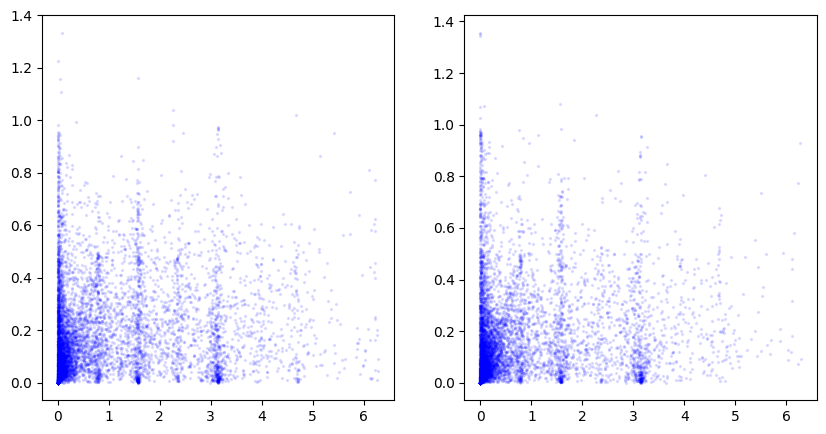

In [5]:
# Difference between raw points at times t and t+1
points = np.stack(subjects_df["raw_points"])
points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)
avg_dist = (dist_points1 + dist_points2)/2.0


positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0
delta_feedbacks = np.reshape(negative_feedbacks[:,:,1:-1],(Nsubj,-1))
                                # Remove the first timestep of each trial (reset to 0)
                                # And the last of each trial (no action after that one !)

# print(negative_feedbacks)
print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)

# np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,:-1] - all_angles[:,:,1:]

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,:-1] - all_distances[:,:,1:]

Nsubj = diff_barycenters.shape[0]


print(diff_distances.shape)
print(diff_barycenters.shape)
print(diff_angle.shape)
print(flattened_distance.shape)


# Get the actions of interest :
diff_angle = np.reshape(np.abs(diff_angle[:,:-1]),(Nsubj,-1))
diff_barycenters = np.reshape(np.abs(diff_barycenters[:,:-1]),(Nsubj,-1))
diff_distances = np.reshape(np.abs(diff_distances[:,:-1]),(Nsubj,-1))
diff_points = np.reshape(np.abs(avg_dist[:,:-1]),(Nsubj,-1))

# plot_df = subjects_df[['feedback_noise_std','final_performance']].copy()
# plot_df["Angle"] = list(diff_angle)
# plot_df["Position"] = list(diff_barycenters)
# plot_df["Distance"] = list(diff_distances)
# plot_df["Points"] = list(diff_points)
# plot_df['performance_category'] = pd.cut(plot_df['final_performance'], bins=np.linspace(0-1e-5,1+1e-5,4), labels=["0-0.33","0.33-0.67","0.37-1.0"], include_lowest=True)


# plot_df = plot_df[plot_df['final_performance'].between(*perf_interv)]

print(plot_df)
print(exploded_df)
fig,axs = plt.subplots(1,2,figsize=(10,5))
window = 50
for subj in range(Nsubj):
    axs[0].scatter(diff_angle[subj][:window],diff_barycenters[subj][:window],alpha=0.1,s=2,color='blue')
    axs[1].scatter(diff_angle[subj][-window:],diff_barycenters[subj][-window:],alpha=0.1,s=2,color='blue')